In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [ ]:
def custom_date_parser(x):
        return datetime.strptime(x, '%Y-%m-%d:%H:%M:%S')


In [ ]:
df = pd.read_csv('/content/humidity_data.csv', index_col='time', parse_dates=True, date_parser=custom_date_parser)

# df.index.freq='MS'

<ipython-input-3-dbaea4fb2c51>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/humidity_data.csv', index_col='time', parse_dates=True, date_parser=custom_date_parser)


In [ ]:
print(df.iloc[2711])


humidity    69
Name: 2024-04-22 23:00:00, dtype: int64


<Axes: xlabel='time'>

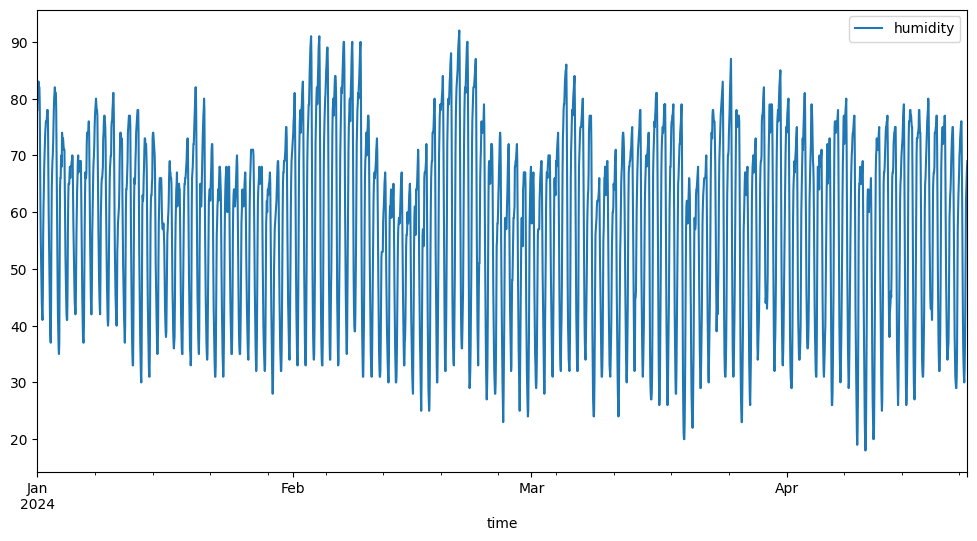

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

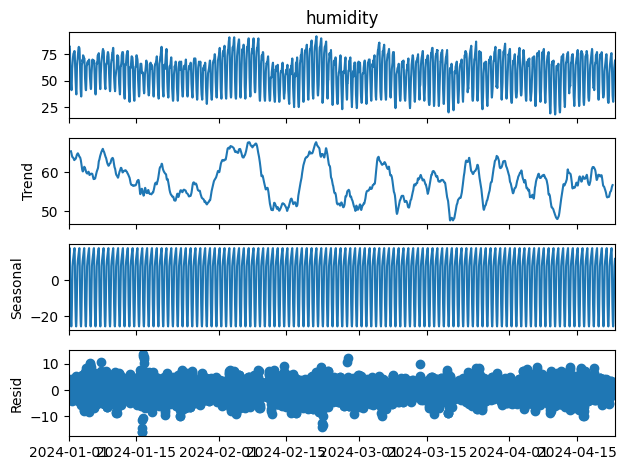

In [ ]:
results = seasonal_decompose(df['humidity'])
results.plot();

In [ ]:
len(df)

2712

In [ ]:
train = df.iloc[:2712]


In [ ]:
train = df.iloc[:1890]
test = df.iloc[1890:]

**GÍA TRỊ ĐẦU TIÊN CỦA TEST LÀ THẰNG INDEX CUỐI CỦA TRAIN : 1890, TỨC LÀ TIME CỦA INDEX 1889  + 1HOUR**

In [ ]:
from datetime import datetime, timedelta
firstTime=train.iloc[2711].name
firstTime_plus_one_hour = firstTime + timedelta(hours=1)
print(firstTime_plus_one_hour)

2024-04-23 00:00:00


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

(                     humidity
 time                         
 2024-01-01 00:00:00        78
 2024-01-01 01:00:00        81
 2024-01-01 02:00:00        82
 2024-01-01 03:00:00        83
 2024-01-01 04:00:00        83,
                      humidity
 time                         
 2024-04-22 19:00:00        62
 2024-04-22 20:00:00        64
 2024-04-22 21:00:00        66
 2024-04-22 22:00:00        68
 2024-04-22 23:00:00        69)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)


In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
print(scaled_train)

# New Section

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# We do the same thing, but now instead for 12 months
n_input = 24
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
2688/2688 [==============================] - 41s 15ms/step - loss: 0.0117
Epoch 2/50
2688/2688 [==============================] - 40s 15ms/step - loss: 0.0022
Epoch 3/50
2688/2688 [==============================] - 39s 15ms/step - loss: 0.0015
Epoch 4/50
2688/2688 [==============================] - 39s 15ms/step - loss: 0.0011
Epoch 5/50
2688/2688 [==============================] - 40s 15ms/step - loss: 9.5963e-04
Epoch 6/50
2688/2688 [==============================] - 39s 15ms/step - loss: 8.5484e-04
Epoch 7/50
2688/2688 [==============================] - 39s 15ms/step - loss: 7.7712e-04
Epoch 8/50
2688/2688 [==============================] - 40s 15ms/step - loss: 7.4688e-04
Epoch 9/50
2688/2688 [==============================] - 40s 15ms/step - loss: 7.1426e-04
Epoch 10/50
2688/2688 [==============================] - 40s 15ms/step - loss: 7.1827e-04
Epoch 11/50
2688/2688 [==============================] - 40s 15ms/step - loss: 6.8896e-04
Epoch 12/50
2688/2688 [============

**PASS**

In [ ]:
import joblib

joblib.dump(model, 'humidity_model.joblib')

['humidity_model.joblib']

In [ ]:
model = joblib.load('humidity_model.joblib')


**PASS END**

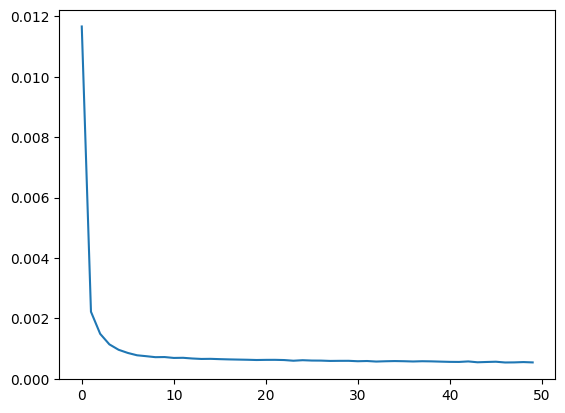

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**PASS**

In [ ]:
last_train_batch = scaled_train[-n_input:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 26ms/step


array([[0.51919913]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.5])

**PASS END**

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(600):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
print(true_predictions)

[[69.8142767 ]
 [70.56175661]
 [71.36515152]
 [72.22034621]
 [73.08203793]
 [73.8661623 ]
 [74.25499141]
 [72.80501235]
 [64.98683238]
 [55.86683464]
 [47.92034614]
 [41.46572554]
 [36.69093007]
 [33.67399901]
 [32.30801153]
 [32.8131299 ]
 [35.92035329]
 [41.66614312]
 [50.56198025]
 [60.17299962]
 [65.41328955]
 [67.72476625]
 [68.98563027]
 [69.80218244]
 [70.47438419]
 [71.15141129]
 [71.90467811]
 [72.73078394]
 [73.57288754]
 [74.37757039]
 [75.02711415]
 [75.05427551]
 [69.77262163]
 [60.99524164]
 [52.68250042]
 [45.70466417]
 [40.2489447 ]
 [36.48697066]
 [34.39702797]
 [33.93203634]
 [35.76793122]
 [40.32305843]
 [47.52463186]
 [56.96100783]
 [64.15783751]
 [67.42302728]
 [69.13364601]
 [70.1422596 ]
 [70.87289929]
 [71.57610416]
 [72.33157635]
 [73.15465641]
 [74.01656866]
 [74.87409663]
 [75.65080214]
 [76.07066083]
 [73.89887238]
 [65.77738762]
 [56.88471079]
 [49.37959659]
 [43.29847336]
 [38.81619841]
 [36.03325731]
 [34.84695029]
 [35.54217061]
 [38.84670973]
 [44.83520


**USE THIS FUNCTION TO CREATE <TIME,TEMP>**



In [ ]:
true_predictions_flat = true_predictions[:, 0]
time_range = pd.date_range(start=firstTime_plus_one_hour, periods=len(true_predictions_flat), freq='H')
data = pd.DataFrame({'time': time_range, 'humidity': true_predictions_flat})
print(data)



                   time   humidity
0   2024-04-23 00:00:00  69.814277
1   2024-04-23 01:00:00  70.561757
2   2024-04-23 02:00:00  71.365152
3   2024-04-23 03:00:00  72.220346
4   2024-04-23 04:00:00  73.082038
..                  ...        ...
595 2024-05-17 19:00:00  75.444238
596 2024-05-17 20:00:00  65.529901
597 2024-05-17 21:00:00  56.762013
598 2024-05-17 22:00:00  49.692812
599 2024-05-17 23:00:00  44.128551

[600 rows x 2 columns]


In [ ]:
gifile_path = "predicted_humidity_data.csv"

# Export the DataFrame to a CSV file
data.to_csv(file_path, index=False)

In [ ]:
test['Predictions'] = true_predictions


In [ ]:
print(test)

                     temp  Predictions
time                                  
2024-03-19 18:00:00    30    30.307186
2024-03-19 19:00:00    29    29.038169
2024-03-19 20:00:00    28    28.341681
2024-03-19 21:00:00    28    27.894080
2024-03-19 22:00:00    27    27.559813
...                   ...          ...
2024-04-14 19:00:00    30    84.108540
2024-04-14 20:00:00    29   110.574020
2024-04-14 21:00:00    29   160.212173
2024-04-14 22:00:00    29   130.499542
2024-04-14 23:00:00    28    98.152779

[630 rows x 2 columns]


<Axes: xlabel='time'>

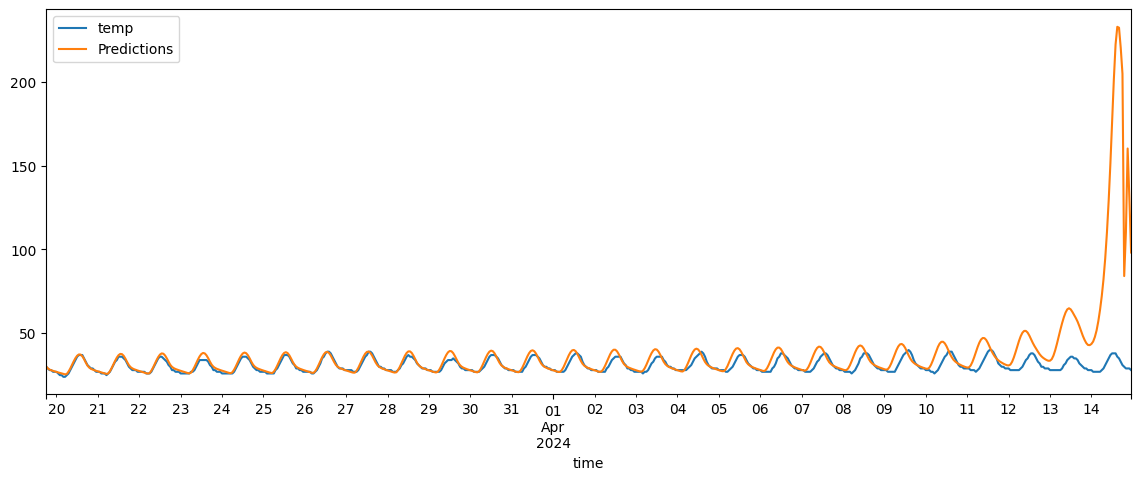

In [ ]:
test.plot(figsize=(14,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['temp'],test['Predictions']))
print(rmse)

22.739738748524935
